In [56]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [57]:
df = pd.read_excel("../Data/K45_CNTT_08.11.24_send.xlsx")
df.head()

,Mã SV,Họ và tên,Ngày sinh,Nơi sinh,Giới tính,Lớp,Năm học,Học kỳ,Mã học phần,Tên học phần,Số TC,Điểm giữa kỳ,Điểm cuối kỳ,Điểm trung bình,Tổng kết chữ,Đạt
0,4501104248,Nguyễn Thị Thùy Trang,30/06/2000,ĐẮK LẮK,False,45.01.CNTT.C,2021-2022,HK02,COMP1049,Bảo mật và an ninh mạng,3,8.50,9.0,8.8,A,x
1,4501104248,Nguyễn Thị Thùy Trang,30/06/2000,ĐẮK LẮK,False,45.01.CNTT.C,2021-2022,HK02,EARC1001,Mỹ thuật cơ bản,3,6.60,4.0,5.3,D+,x
2,4501104248,Nguyễn Thị Thùy Trang,30/06/2000,ĐẮK LẮK,False,45.01.CNTT.C,2021-2022,HK02,ENGL2403,Tiếng Anh học phần III,3,8.82,8.7,8.8,A,x
3,4501104248,Nguyễn Thị Thùy Trang,30/06/2000,ĐẮK LẮK,False,45.01.CNTT.C,2021-2022,HK03,COMP1084,Thương mại điện tử,3,9.00,7.0,7.6,B,x
4,4501104248,Nguyễn Thị Thùy Trang,30/06/2000,ĐẮK LẮK,False,45.01.CNTT.C,2021-2022,HK03,COMP1311,Bảo mật cơ sở dữ liệu,3,8.50,6.5,7.5,B,x


In [58]:
import json
import matplotlib.pyplot as plt

In [59]:
with open('../Lib/class_course.json', 'r', encoding='utf-8') as file:
    course_mapping = json.load(file)

def course_class(df):
        return [which_class(course_name)
                for course_name in df["Tên học phần"]]

def which_class(course_name):
    for class_name in course_mapping.keys():
        if course_name in course_mapping[class_name]["CoursesName"]:
            return class_name
    return "Unknows"

In [60]:
method = "k_means"
def visualize(name, index, data, labels, labels_name): 
    indexs = [item for item in range(len(labels_name)) if item != index]
    X_reduced = data
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    axes[0].scatter(X_reduced[:, index], X_reduced[:, indexs[0]], c=labels, cmap='viridis', s=50)
    axes[0].set_xlabel(f'{labels_name[index]}')
    axes[0].set_ylabel(f'{labels_name[indexs[0]]}')
    axes[0].set_title(f'{method} Clustering {labels_name[index]} & {labels_name[indexs[0]]}')

    axes[1].scatter(X_reduced[:, index], X_reduced[:, indexs[1]], c=labels, cmap='viridis', s=50)
    axes[1].set_xlabel(f'{labels_name[index]}')
    axes[1].set_ylabel(f'{labels_name[indexs[1]]}')
    axes[1].set_title(f'{method} Clustering {labels_name[index]} & {labels_name[indexs[1]]}')

    fig.savefig(f'../Lib/Images/ImagesPassFail/{name}_{labels_name[index]}_{method}.png', dpi=300, bbox_inches='tight')

In [61]:
def radio_fail(labels, index_cluster, df_cluster, df):
    indexs = np.where(labels == index_cluster)[0]
    df_with_indexs = df_cluster.loc[indexs]
    student_indexs = list(df_with_indexs["Index"])
    filtered_df = df[df['Mã SV'].isin(student_indexs)]
    passed_courses = filtered_df[filtered_df['Đạt'] == "x"]
    passed_count_df = passed_courses.groupby('Mã SV').size().reset_index(name='num_pass')
    return passed_count_df['num_pass'].sum() / len(filtered_df)


In [62]:
mapping = {
    0: "Fail",
    1: "Fail",
    2: "Fail",
    3: "Fail",
    4: "Pass"
}
mapping_labels= {
    "Fail": 0,
    "Pass": 1
}

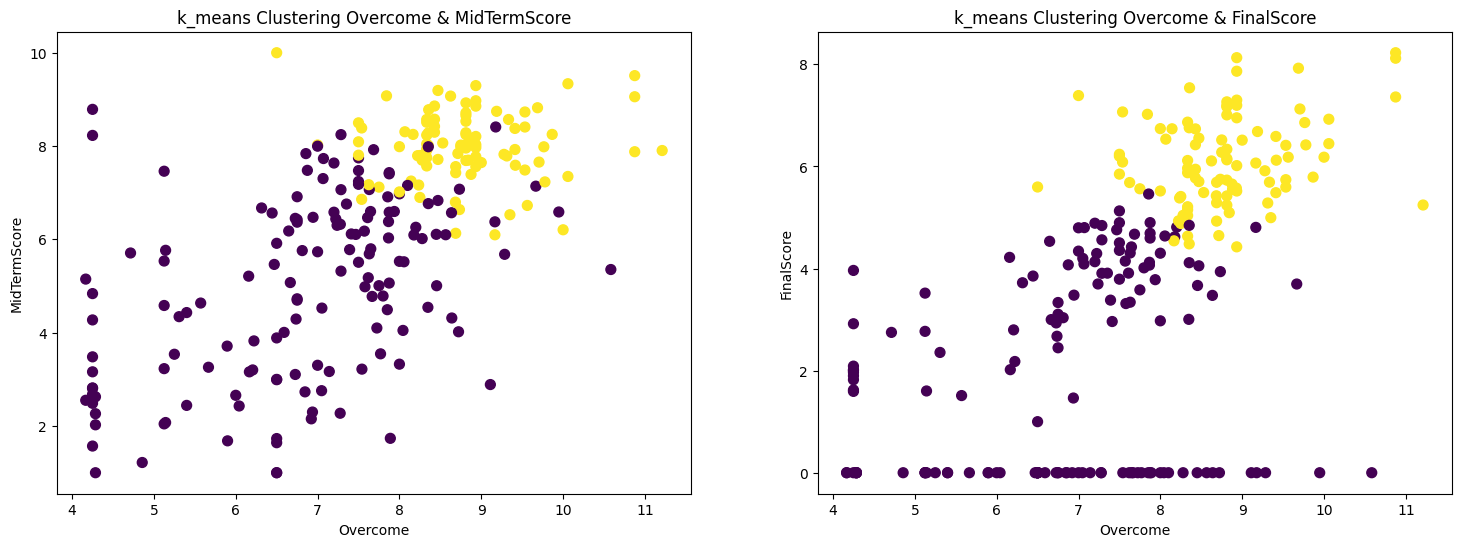

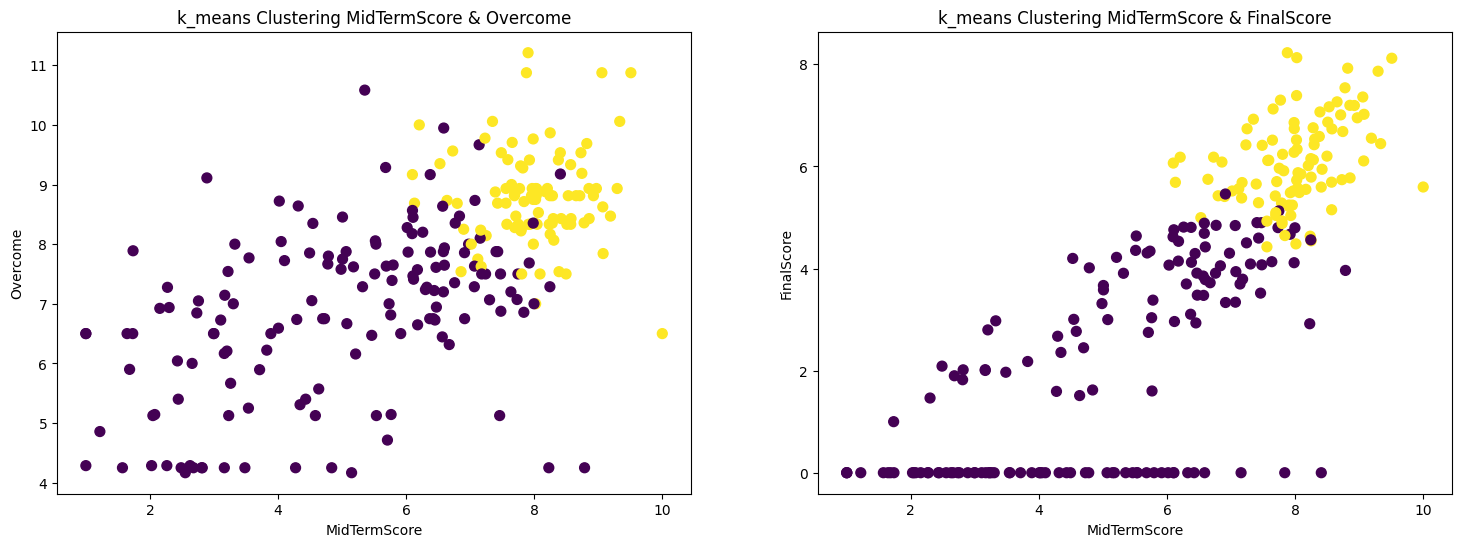

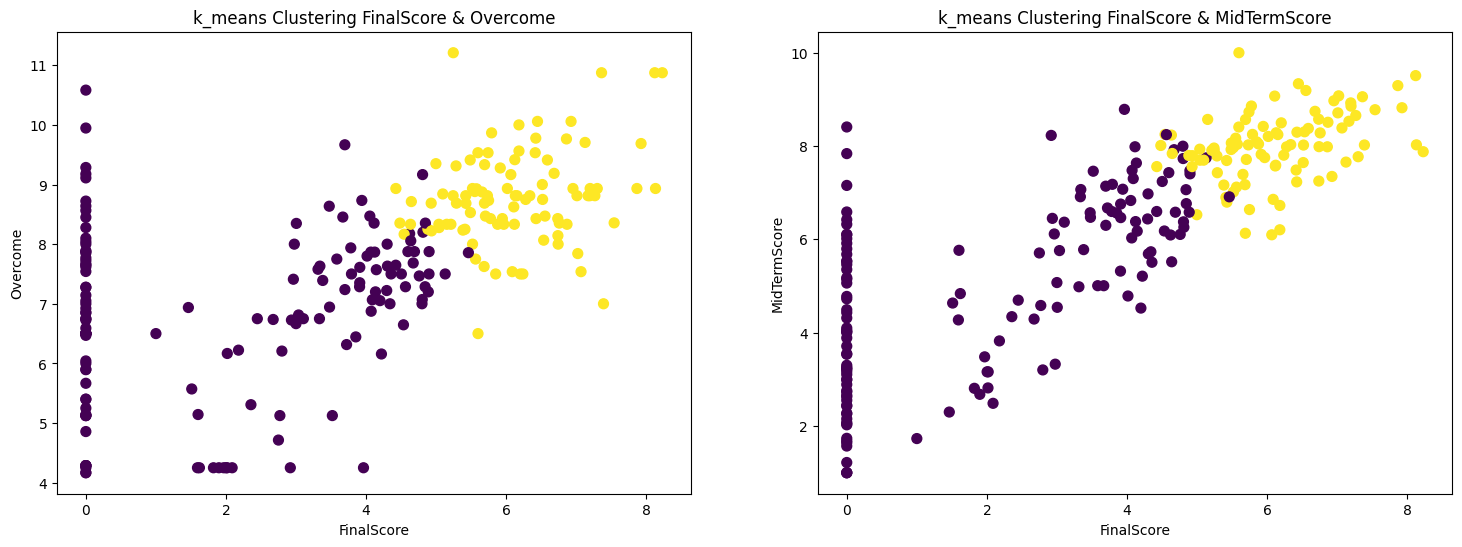

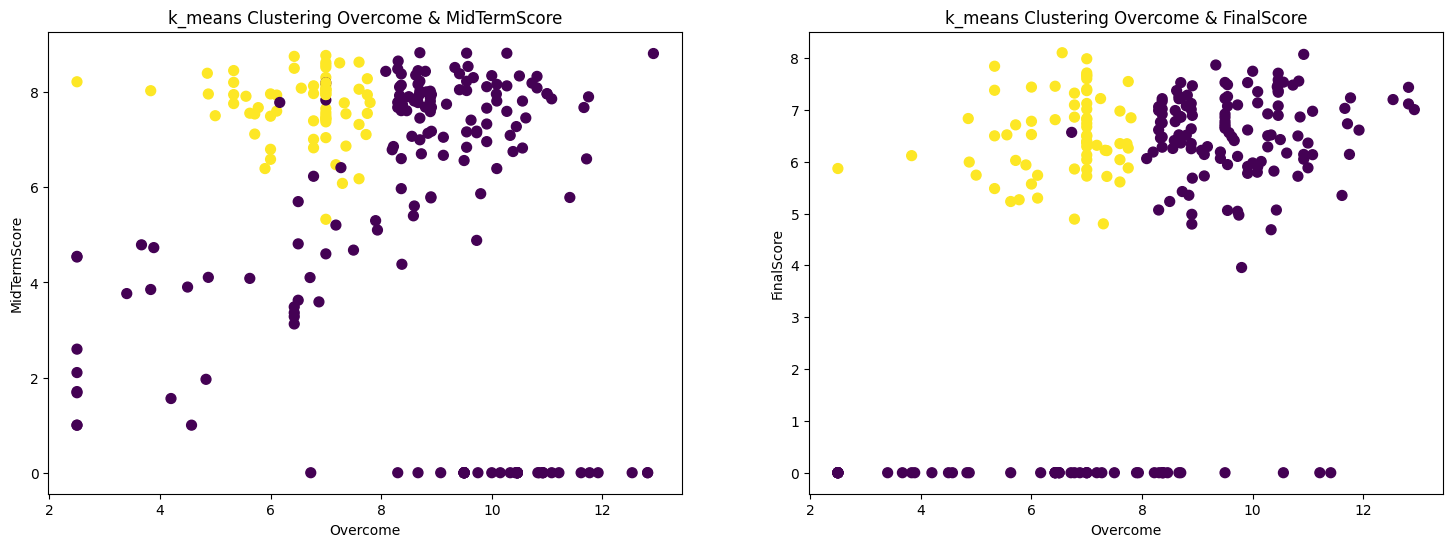

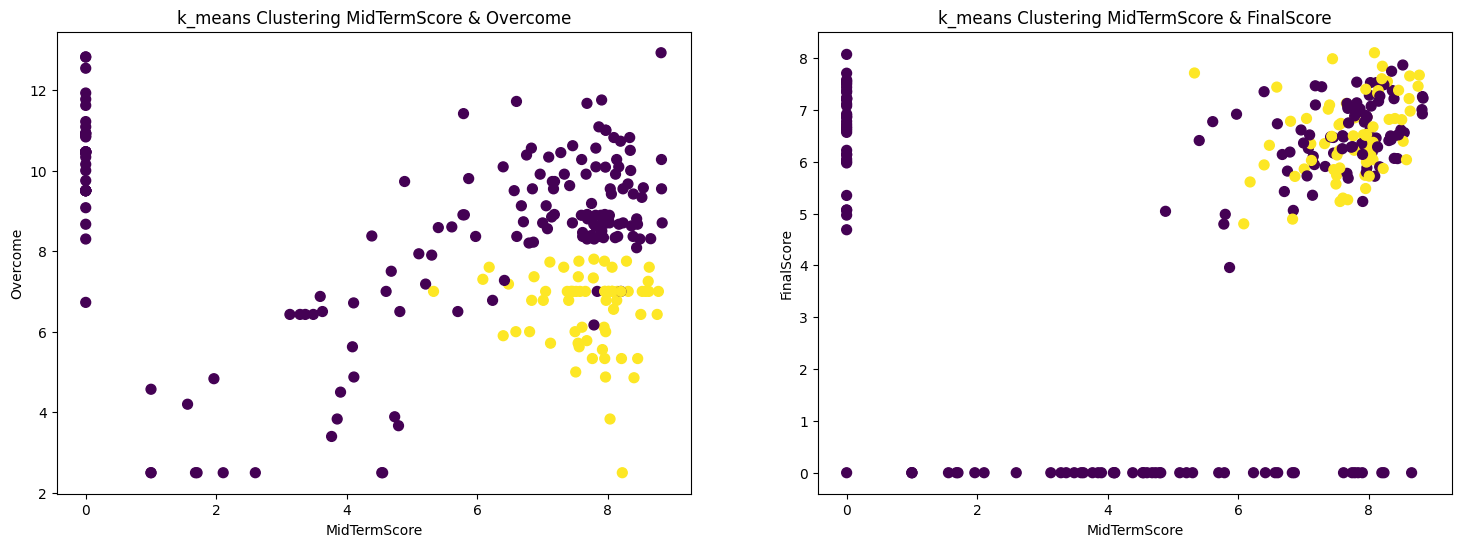

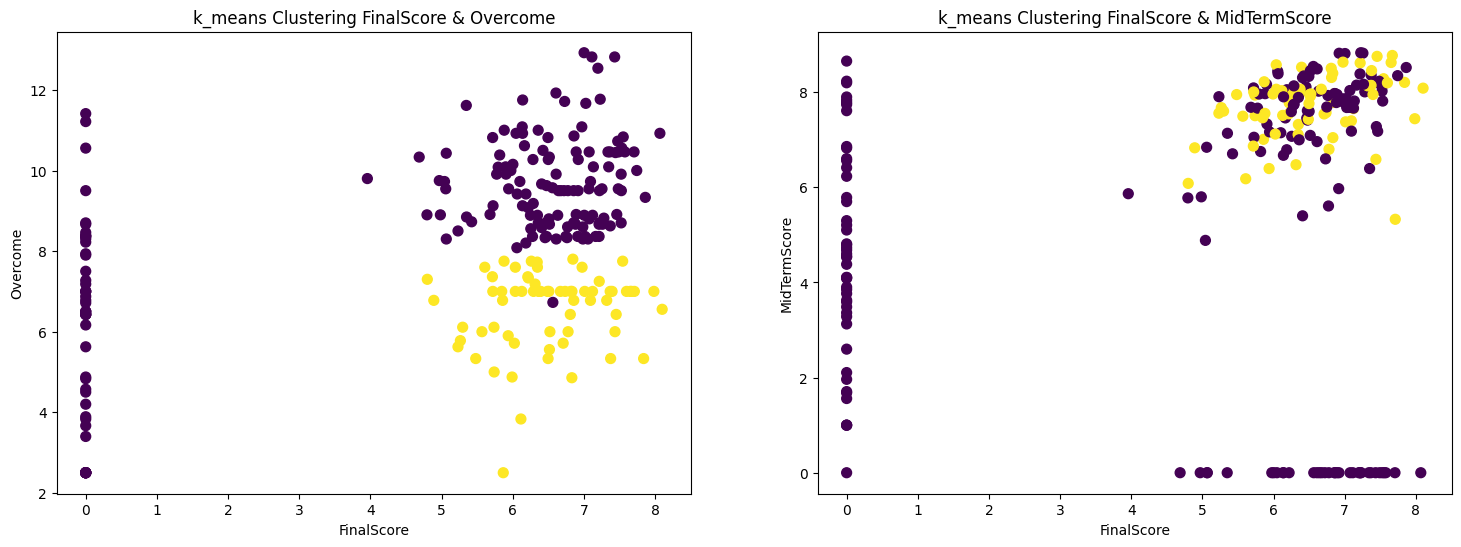

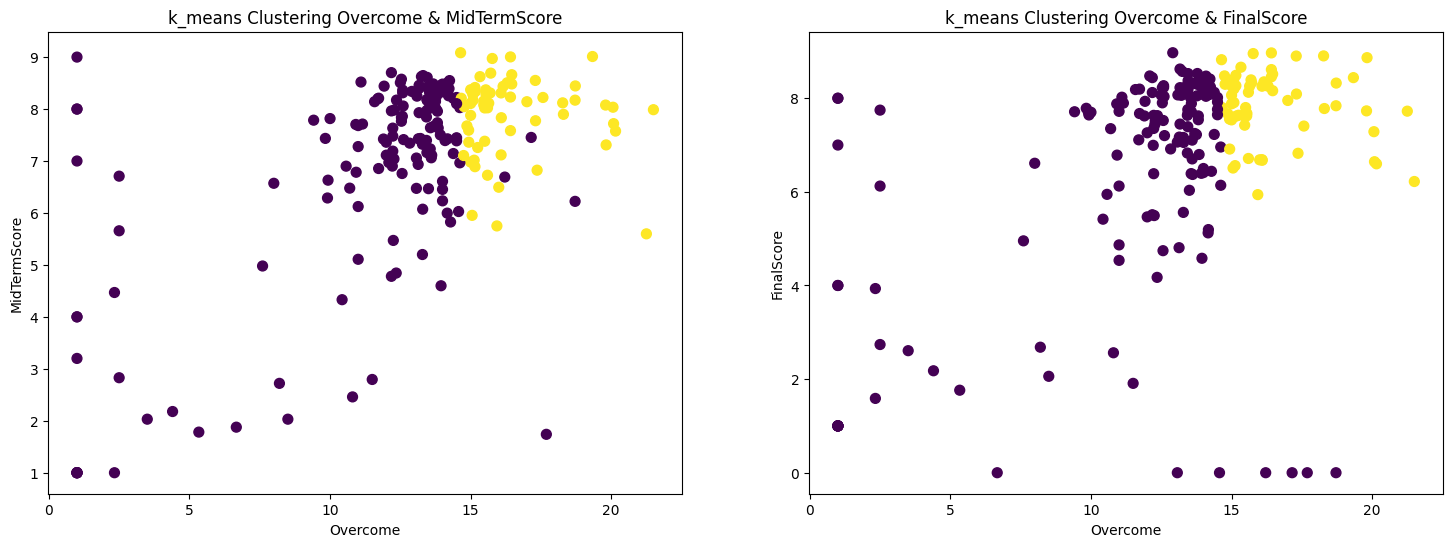

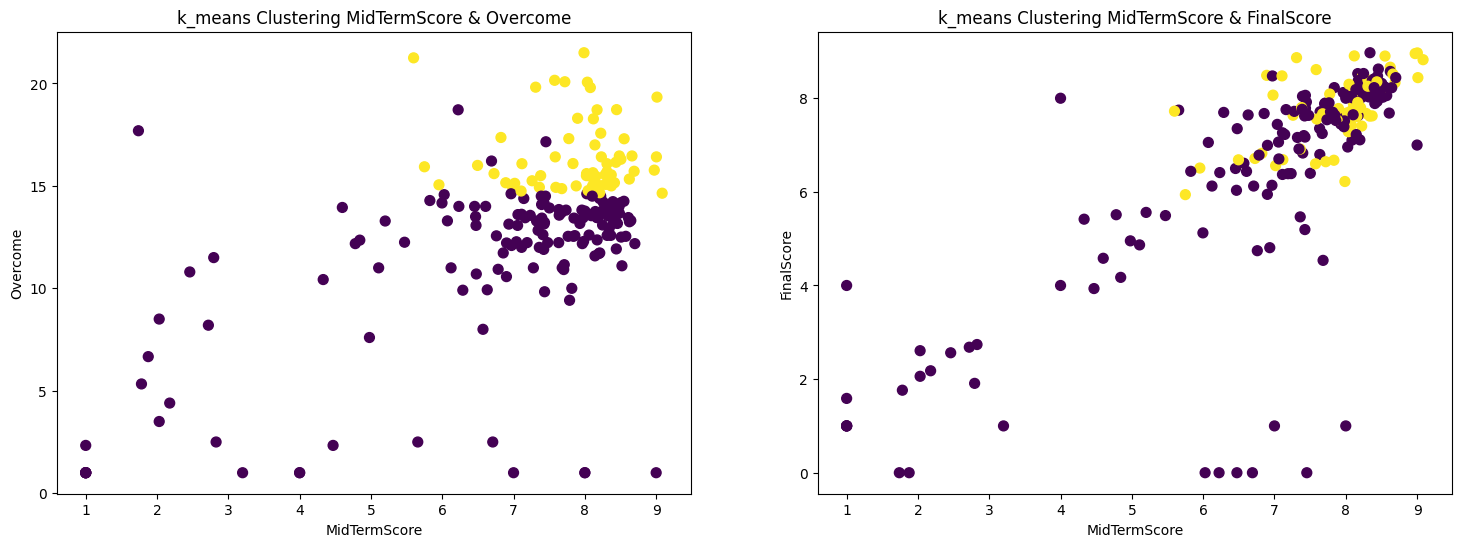

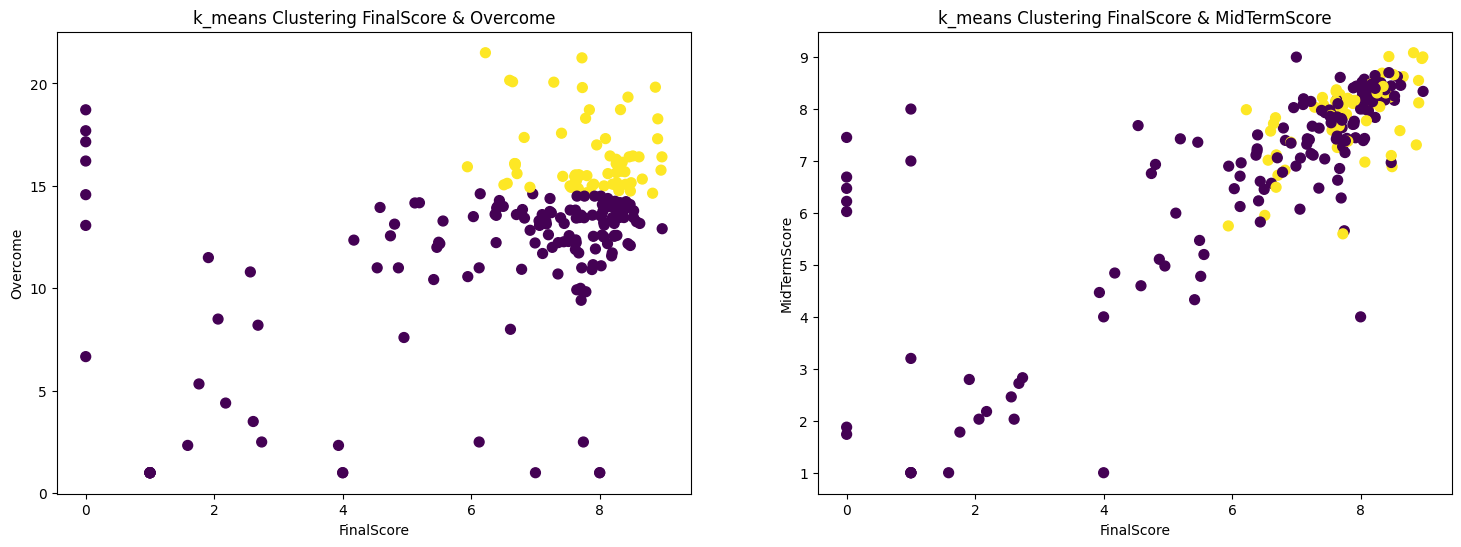

In [63]:
df["CourseClass"] = course_class(df)
df = df[df["CourseClass"] != "Unknows"]
final = {}
for class_name in ["FoundationCourses", "GeneralCourses", "MajorCourses"]:
    labels = np.load(f"../Lib/Labels/{class_name}_k_means.npy")
    df_cluster = pd.read_json(f"../Data/{class_name}.json")
    df_class = df[df["CourseClass"] == class_name]
    result = [radio_fail(labels, i, df_cluster, df_class) for i in range(5)]
    sorted_indices = sorted(range(len(result)), key=lambda x: result[x])
    index_labels = [sorted_indices.index(i) for i in range(len(result))]
    outcome = list(map(lambda x: mapping.get(x, "Unknown"), index_labels))
    final[class_name] = outcome

    df_new = df_cluster.drop(columns=["Index"])
    data = array = df_new.to_numpy()
    labels_name = list(df_new.columns)
    new_labels = [0 if outcome[label] == "Fail" else 1 for label in labels]
    for index in range(3):
        visualize(class_name, index, data, new_labels, labels_name)

In [64]:
with open(f'../Lib/grade.json', 'w', encoding='utf-8') as f:
    json.dump(final, f, ensure_ascii=False, indent=4)